In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras_tuner.tuners import RandomSearch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import random
import os
import keras_tuner as kt

SEED = 42
random.seed(SEED)           # Seed for Python's random module
np.random.seed(SEED)        # Seed for NumPy
tf.random.set_seed(SEED)    # Seed for TensorFlow

# Ensure TensorFlow operations are deterministic
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Load and preprocess the data
data = pd.read_csv("model_data.csv")
data = data.drop(columns=['Unnamed: 0'])
X = data.drop(columns=['target_cost'])
y = data['target_cost']

# Scale data
scaler = StandardScaler()
X_scaled = X #scaler.fit_transform(X)

# Split Data into training, validation, test sets
# 80%:10%:10% ~roughly
#X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=(12/57), random_state=42)
#X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Split the data into 60% training and 40% for temp (which will be split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
# Split the temp data into validation and test sets, each being 50% of temp data, which is 20% of the original data
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


Using TensorFlow backend


In [2]:
# Create RMSE
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.keras.losses.MeanSquaredError()(y_true, y_pred))

In [3]:
tb_callback = tf.keras.callbacks.TensorBoard(log_dir='logs/',histogram_freq=1)
# Define the model
def build_model(hp):
    model = tf.keras.Sequential()
    
    model.add(layers.InputLayer(input_shape=(X_train.shape[1],))) # Input layer
    
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=10, max_value=150, step=5),
                               activation=hp.Choice('activation_' + str(i), ['relu', 'tanh', 'sigmoid', 'elu', 'swish']),
                               kernel_regularizer=l2(0.01))) # l2 regularization))
        model.add(BatchNormalization())  # Batch Normalization
        model.add(Dropout(0.5))  # Dropout
        
    model.add(layers.Dense(1)) # Output layer
    
    rates = [0.01, 0.001, 0.0001]

    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', rates)),
                  loss='mse',
                  #metrics=['mae'])
                  metrics=[root_mean_squared_error])
    
    return model

# Create early stopping and learning rate reduction callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    #objective='val_mae',
    objective=kt.Objective('val_root_mean_squared_error', direction='min'),
    max_trials=30,
    executions_per_trial=2,
    directory='model_dir',
    project_name='target_cost_tuning'
)

# Search for the best model
tuner.search(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]



# Train the best model on the full training data
history = best_model.fit(np.vstack([X_train, X_val]),
                         np.hstack([y_train, y_val]),
                         epochs=1000,
                         batch_size=5,
                         validation_data=(X_val, y_val),
                         callbacks=[tb_callback, early_stop, lr_schedule])

# Save the model
best_model.save("best_model.keras")


Trial 30 Complete [00h 00m 08s]
val_root_mean_squared_error: 1.8059642910957336

Best val_root_mean_squared_error So Far: 1.3446974158287048
Total elapsed time: 00h 05m 15s
Epoch 1/1000
9/9 [==============================] - 1s 32ms/step - loss: 3.4587 - root_mean_squared_error: 1.7438 - val_loss: 1.8356 - val_root_mean_squared_error: 1.3430 - lr: 1.0000e-04
Epoch 2/1000
9/9 [==============================] - 0s 12ms/step - loss: 5.3825 - root_mean_squared_error: 2.2328 - val_loss: 1.8391 - val_root_mean_squared_error: 1.3506 - lr: 1.0000e-04
Epoch 3/1000
9/9 [==============================] - 0s 12ms/step - loss: 4.8806 - root_mean_squared_error: 2.0832 - val_loss: 1.8410 - val_root_mean_squared_error: 1.3575 - lr: 1.0000e-04
Epoch 4/1000
9/9 [==============================] - 0s 12ms/step - loss: 4.3460 - root_mean_squared_error: 1.9457 - val_loss: 1.8453 - val_root_mean_squared_error: 1.3654 - lr: 1.0000e-04
Epoch 5/1000
9/9 [==============================] - 0s 13ms/step - loss: 5.

In [4]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 55)                330       
                                                                 
 batch_normalization (BatchN  (None, 55)               220       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 55)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 56        
                                                                 
Total params: 606
Trainable params: 496
Non-trainable params: 110
_________________________________________________________________


In [5]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Input layer details
input_shape = best_model.layers[0].input_shape
print(f"Input layer shape: {input_shape[1]}")

# Details of hidden layers
print(f"The optimal number of layers is {best_hps.get('num_layers')}.")
for i in range(best_hps.get('num_layers')):
    print(f"The optimal number of units in layer {i+1} is {best_hps.get('units_' + str(i))}.")

# Output layer details
output_shape = best_model.layers[-1].output_shape
print(f"Output layer shape: {output_shape[1]}")

print(f"The optimal learning rate is {best_hps.get('learning_rate')}.")

# Try 128 layer 1

Input layer shape: 5
The optimal number of layers is 1.
The optimal number of units in layer 1 is 55.
Output layer shape: 1
The optimal learning rate is 0.0001.


Validation Set

In [6]:

# Predictions
y_pred = best_model.predict(X_val)

# Metrics
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)
mape = mean_absolute_percentage_error(y_val, y_pred)

print("Val MAE:", mae)
print("Val MSE:", mse)
print("Val RMSE:", rmse)
print("Val R^2:", r2)
print("Val MAPE:", mape)



1/1 [==============================] - 0s 79ms/step
Val MAE: 1.072423538618508
Val MSE: 1.7361380583137753
Val RMSE: 1.3176259174415839
Val R^2: 0.1830352536673837
Val MAPE: 2.46501656502677


Test Set

In [7]:

# Predictions
y_pred = best_model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
residuals = y_test - y_pred.squeeze()

print("Test MAE:", mae)
print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R^2:", r2)
print("Test MAPE:", mape)


1/1 [==============================] - 0s 20ms/step
Test MAE: 0.9116385442046656
Test MSE: 1.0439053616883045
Test RMSE: 1.02171686963087
Test R^2: -0.5258167848504329
Test MAPE: 3.101343017125684


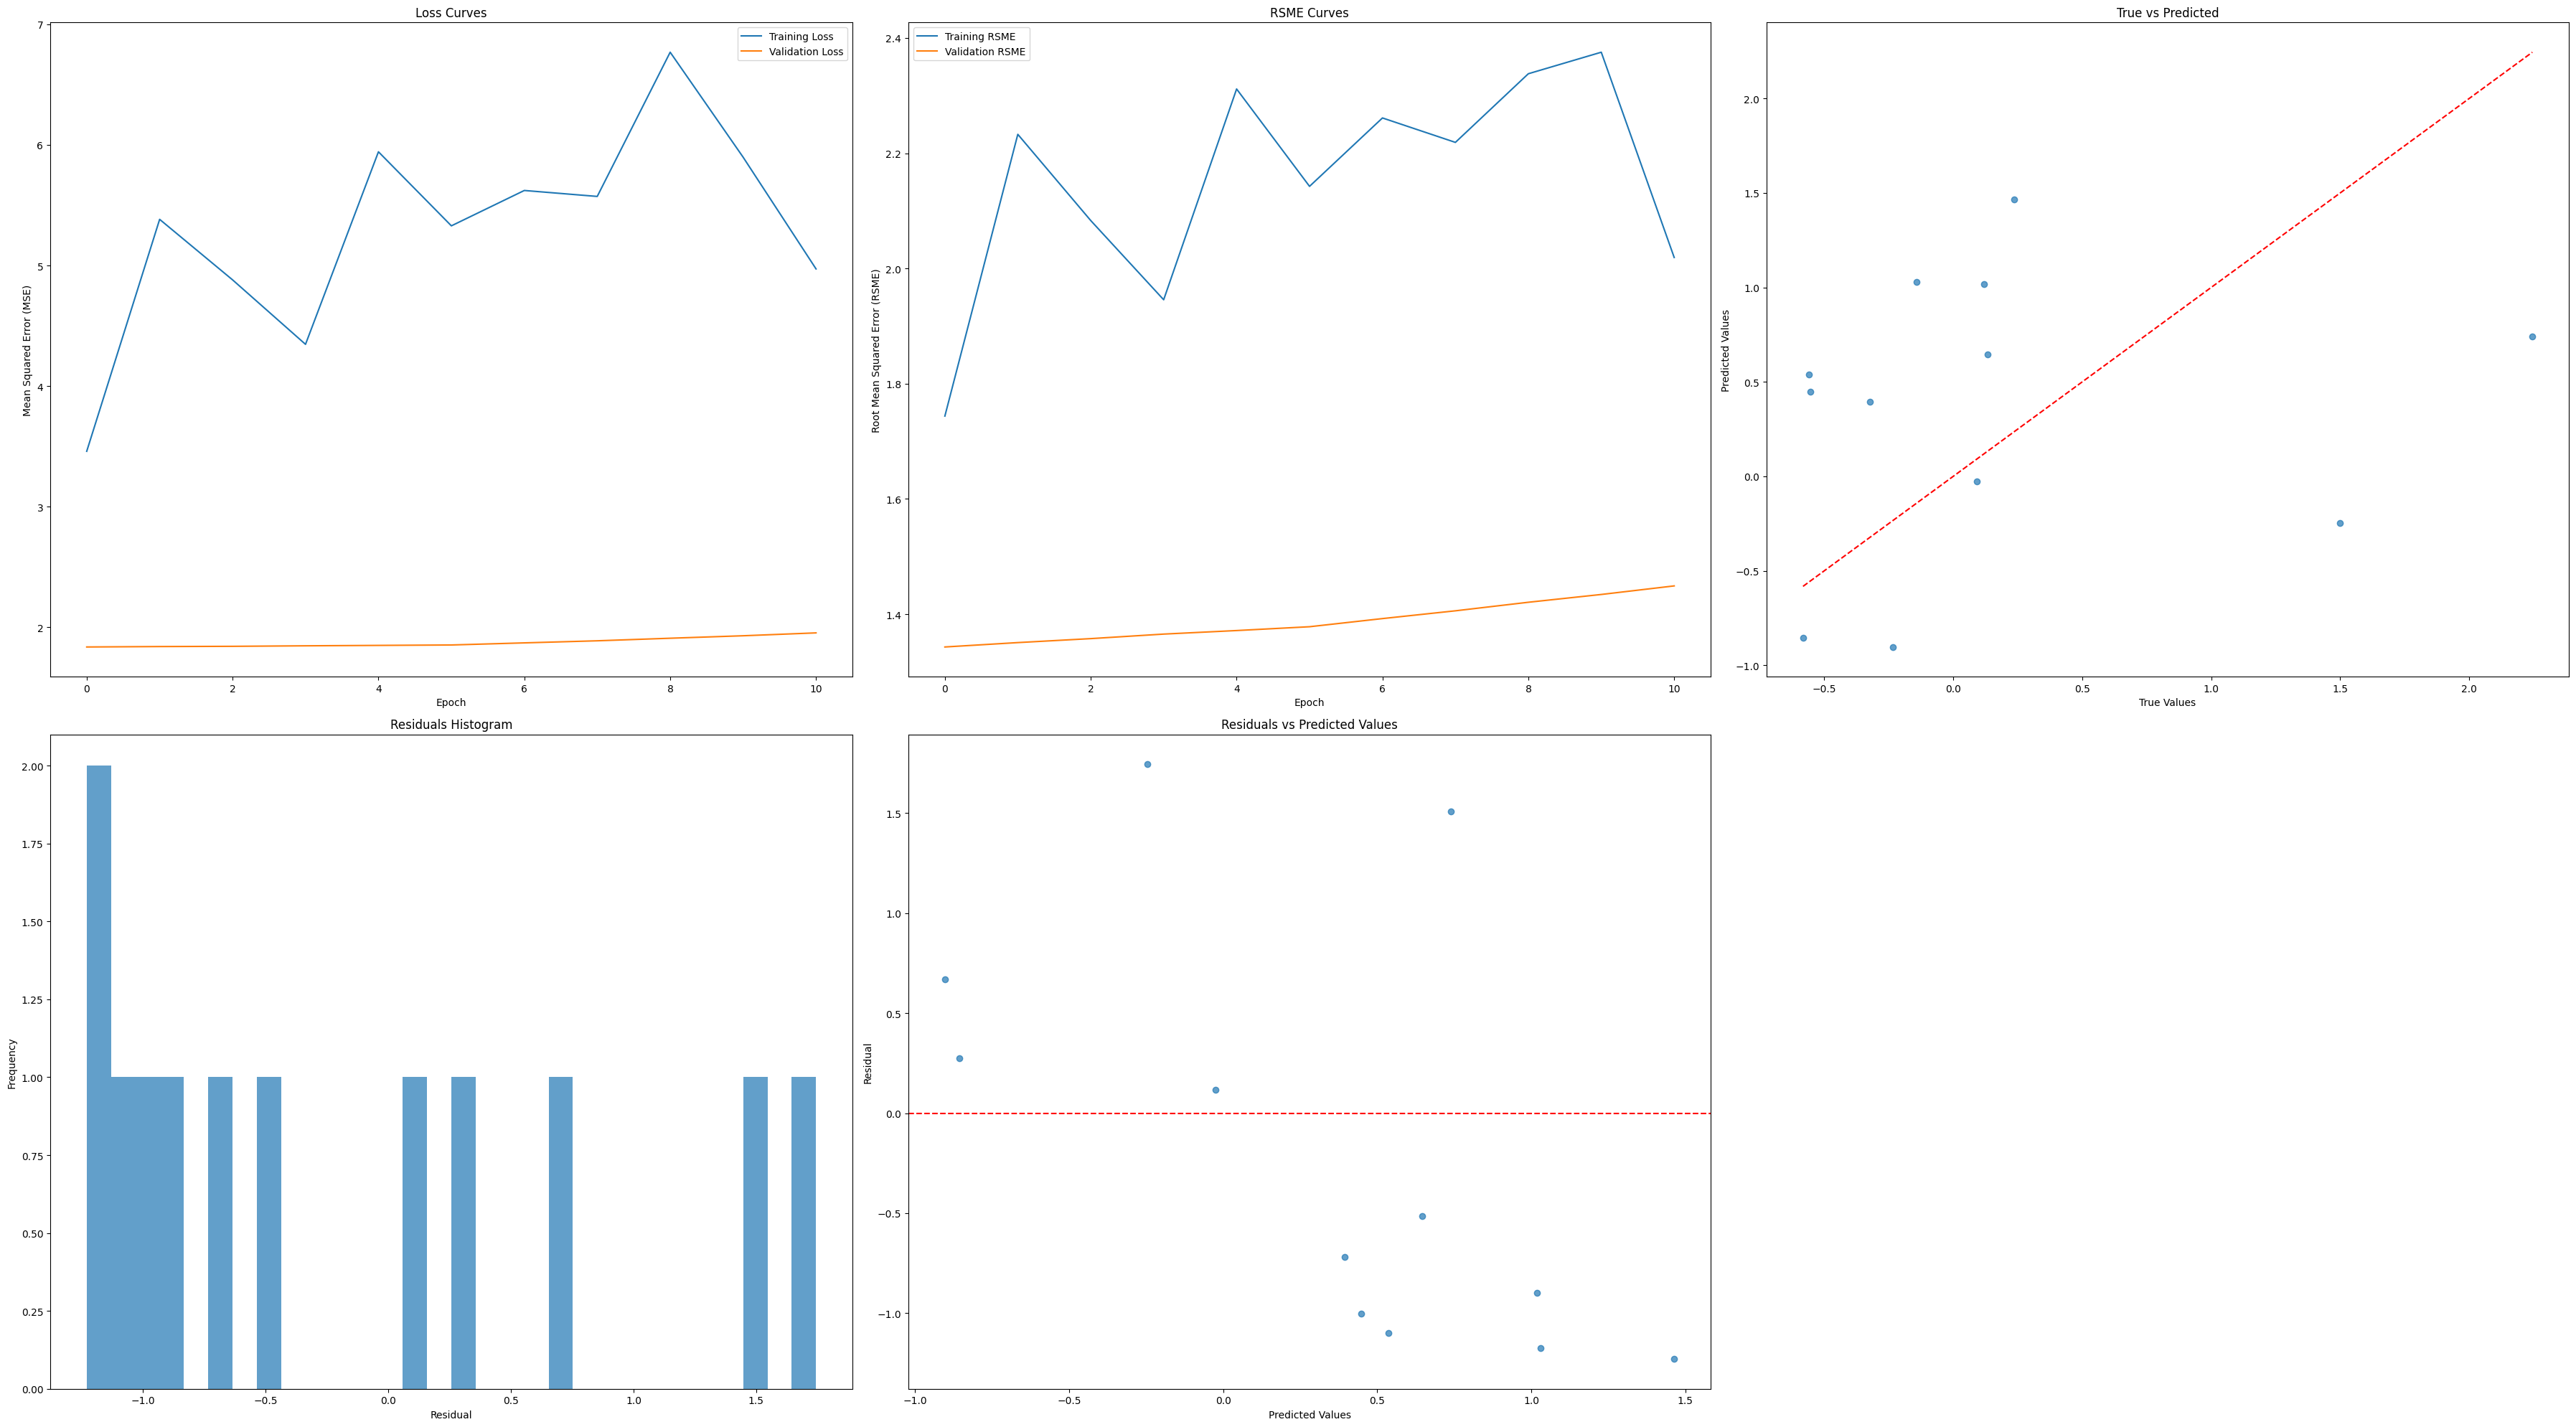

In [8]:

# Plotting
plt.figure(figsize=(36, 20))

# Loss Curves
plt.subplot(2, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()

'''
# MAE Curves
plt.subplot(2, 3, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Curves')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
'''

# RSME Curves
plt.subplot(2, 3, 2)
plt.plot(history.history['root_mean_squared_error'], label='Training RSME')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RSME')
plt.title('RSME Curves')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error (RSME)')
plt.legend()

# True vs Predicted
plt.subplot(2, 3, 3)
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted')

# Residuals Histogram
plt.subplot(2, 3, 4)
plt.hist(residuals, bins=30, alpha=0.7)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')

# Residuals Plot
plt.subplot(2, 3, 5)
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residual')
plt.title('Residuals vs Predicted Values')

plt.tight_layout()
plt.show()


In [9]:
# Predictions
y_preds = best_model.predict(X_test)

y_preds


1/1 [==============================] - 0s 22ms/step


array([[ 0.6466781 ],
       [ 0.73837304],
       [ 0.39404634],
       [ 1.0181302 ],
       [ 0.53718257],
       [-0.85566825],
       [ 0.44773954],
       [-0.0250707 ],
       [-0.90325034],
       [ 1.0303341 ],
       [ 1.4639026 ],
       [-0.24570605]], dtype=float32)

In [10]:
y_test

17    0.133429
12    2.244818
0    -0.323041
45    0.119366
4    -0.560242
43   -0.582371
5    -0.553861
26    0.091327
55   -0.234381
30   -0.143361
3     0.234851
36    1.498075
Name: target_cost, dtype: float64

### Manual Model

In [36]:
#from sklearn.model_selection import train_test_split

#data2 = pd.read_csv("model_data.csv")

# Drop the 'Unnamed: 0' column
#data2 = data.drop(columns=['Unnamed: 0'])

# Splitting the dataset into training and testing sets
#X = data2.drop(columns=['target_cost'])
#y = data2['target_cost']

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#X_train.shape, X_test.shape


In [37]:
#import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [38]:
# Initialize the model
model2 = Sequential()

# Add input layer
model2.add(Dense(20, activation='relu', input_shape=(X_train.shape[1],)))

# Add two hidden layers
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))

# Add output layer
model2.add(Dense(1))

# optimizer settings
optimizer2 = tf.keras.optimizers.Adam(learning_rate=.01)

# Compile the model
model2.compile(optimizer=optimizer2, loss='mse', metrics=['mae'])

# Summary of the model architecture
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 dense_2 (Dense)             (None, 20)                120       
                                                                 
 dense_3 (Dense)             (None, 128)               2688      
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 11,129
Trainable params: 11,129
Non-trainable params: 0
_________________________________________________________________


In [39]:
history = model2.fit(X_train, y_train, epochs=100, batch_size=5, validation_split=0.1, verbose=1)

Epoch 1/100
8/8 [==============================] - 0s 18ms/step - loss: 2145735296.0000 - mae: 22066.1133 - val_loss: 107994896.0000 - val_mae: 7200.5664
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 2144445696.0000 - mae: 22038.9902 - val_loss: 107248664.0000 - val_mae: 7148.3662
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 2139956224.0000 - mae: 21932.2754 - val_loss: 104775208.0000 - val_mae: 6976.3696
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 2126481408.0000 - mae: 21623.0176 - val_loss: 98270104.0000 - val_mae: 6523.3789
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 2088714240.0000 - mae: 20956.1523 - val_loss: 86283464.0000 - val_mae: 5588.3628
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 2042764032.0000 - mae: 20325.3320 - val_loss: 67112528.0000 - val_mae: 4808.9287
Epoch 7/100
8/8 [==============================] - 0s 5ms/step - loss: 1908071680.00

In [40]:
loss, mae = model2.evaluate(X_test, y_test, verbose=1)
print(f"Mean Absolute Error on Test Set: {mae}")


1/1 [==============================] - 0s 84ms/step - loss: 1705909248.0000 - mae: 28646.1309
Mean Absolute Error on Test Set: 28646.130859375
